In [68]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

In [69]:
# Load the JSON data
data_file = 'processed_reactions/all_reactions.json'
with open(data_file, 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

def filter_conf_intervals(row):
    if 'conf_intervals' in row and 'constant_conf_1' in row['conf_intervals'] and 'constant_conf_2' in row['conf_intervals']:
        conf_1 = row['conf_intervals']['constant_conf_1']
        conf_2 = row['conf_intervals']['constant_conf_2']
        
        # Ensure 'r1' and 'r2' are correctly retrieved from the row
        r1 = row.get('r_values', {}).get('constant_1')
        r2 = row.get('r_values', {}).get('constant_2')
        
        if r1 is not None and r2 is not None and conf_1 is not None and conf_2 is not None:
            # Filter condition: Confidence intervals should not be greater than the corresponding r-values
            return (conf_1 <= 1 * r1) and (conf_2 <= 1 * r2)
    
    # If conditions are not met, return True by default, meaning the row will not be filtered out
    return True

In [70]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

print('Initial datapoints: ', len(df_full))
df_full = df_full[df_full.apply(filter_conf_intervals, axis=1)]
print('Datapoints after confidence filter:', len(df_full))

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print('Datapoints after r-product filter: ', len(df_filtered))

Initial datapoints:  1138
Datapoints after confidence filter: 1060
Datapoints after r-product filter:  1037


In [71]:
from sklearn.impute import SimpleImputer

# preprocess data
def ensure_list(seq):
    if isinstance(seq, float) and np.isnan(seq):
        return []
    elif not isinstance(seq, list):
        return [seq]
    else:
        return seq

from sklearn.impute import SimpleImputer

def preprocess_data(df, target_column):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]
    
    print(f"Datapoints after removing None values: {len(df)}")
    
    # Label-Encoding for 'method' and 'calculation_method'
    df['method_encoded'] = pd.Categorical(df['method']).codes
    df['calculation_method_encoded'] = pd.Categorical(df['calculation_method']).codes

    # Extract monomer features
    def extract_monomer_features(monomer_data):
        if isinstance(monomer_data, dict):
            return [
                monomer_data.get('ip', None),
                monomer_data.get('ip_corrected', None),
                monomer_data.get('ea', None),
                monomer_data.get('homo', None),
                monomer_data.get('lumo', None),
                monomer_data.get('global_electrophilicity', None),
                monomer_data.get('global_nucleophilicity', None)
            ]
        else:
            return None
    
    df['monomer1_features'] = df['monomer1_data'].apply(extract_monomer_features)
    df['monomer2_features'] = df['monomer2_data'].apply(extract_monomer_features)

    # Drop rows with any missing monomer features
    df.dropna(subset=['monomer1_features', 'monomer2_features'], inplace=True)

    # Handle solvent logP, fill with zeros if logP is missing
    df['solvent_logP'] = df['logP'].fillna(0)

    # Entferne Zeilen, die in der Zielvariable NaN-Werte enthalten
    df.dropna(subset=[target_column], inplace=True)

    # Combine monomer features and solvent logP into a feature matrix
    monomer1_features = np.vstack(df['monomer1_features'].values)
    monomer2_features = np.vstack(df['monomer2_features'].values)
    solvent_logP = df['solvent_logP'].values.reshape(-1, 1)
    temperature = df['temperature'].values.reshape(-1, 1)
    method_features = df['method_encoded'].values.reshape(-1, 1)
    calculation_method_features = df['calculation_method_encoded'].values.reshape(-1, 1)

    # Combine all features into a single array
    all_features = np.hstack([monomer1_features, monomer2_features, solvent_logP, temperature, method_features, calculation_method_features])

    # Handle any remaining NaN values by imputing them with the column mean
    imputer = SimpleImputer(strategy='mean')
    all_features = imputer.fit_transform(all_features)

    # Define the feature names based on the actual keys
    monomer1_keys = ['ip', 'ip_corrected', 'ea', 'homo', 'lumo', 'global_electrophilicity', 'global_nucleophilicity']
    monomer2_keys = ['ip', 'ip_corrected', 'ea', 'homo', 'lumo', 'global_electrophilicity', 'global_nucleophilicity']

    feature_names = (
        [f'monomer1_{key}' for key in monomer1_keys] +
        [f'monomer2_{key}' for key in monomer2_keys] +
        ['solvent_logP', 'temperature', 'method_encoded', 'calculation_method_encoded']
    )

    # Continuous target variable for regression
    regression_labels = df[target_column].values

    return all_features, regression_labels, feature_names


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/68357554.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/68357554.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4zn44s

Datapoints after removing None values: 1002
Anzahl der Feature-Namen: 18
Anzahl der Koeffizienten: 18
Target: r1r2
Average Training MSE: 1.4839, Average Training R2: 0.0535
Average Test MSE: 230.5975, Average Test R2: -0.0054
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [0, 1, 2, 3, 4, 5]}, 'ridge__alpha': 100.0, 'ridge__solver': 'saga'}
Average Feature Coefficients:
monomer1_ip: -0.0329
monomer1_ip_corrected: -0.0329
monomer1_ea: -0.0060
monomer1_homo: -0.0006
monomer1_lumo: -0.0000
monomer1_global_electrophilicity: -0.0135
monomer1_global_nucleophilicity: 0.0329
monomer2_ip: -0.0025
monomer2_ip_corrected: -0.0025
monomer2_ea: 0.0504
monomer2_homo: -0.0031
monomer2_lumo: 0.0005
monomer2_global_electrophilicity: 0.0111
monomer2_global_nucleophilicity: 0.0025
solvent_logP: -0.1136
temperature: 0.0037
method_encoded: -0.0493
calculation_method_encoded: -0.0085


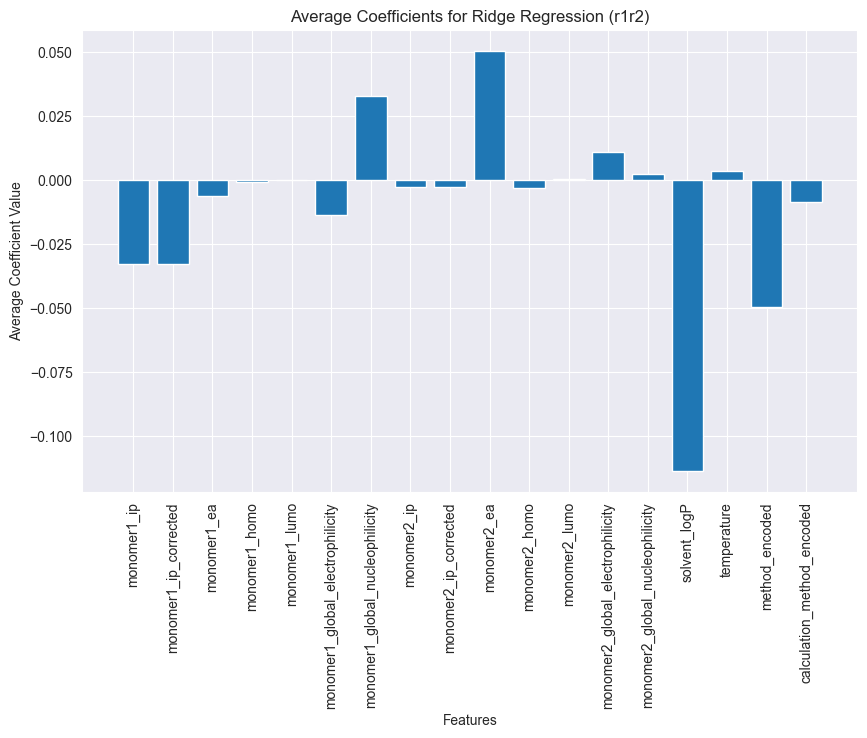

Best model saved as best_ridge_model_r1r2.pkl


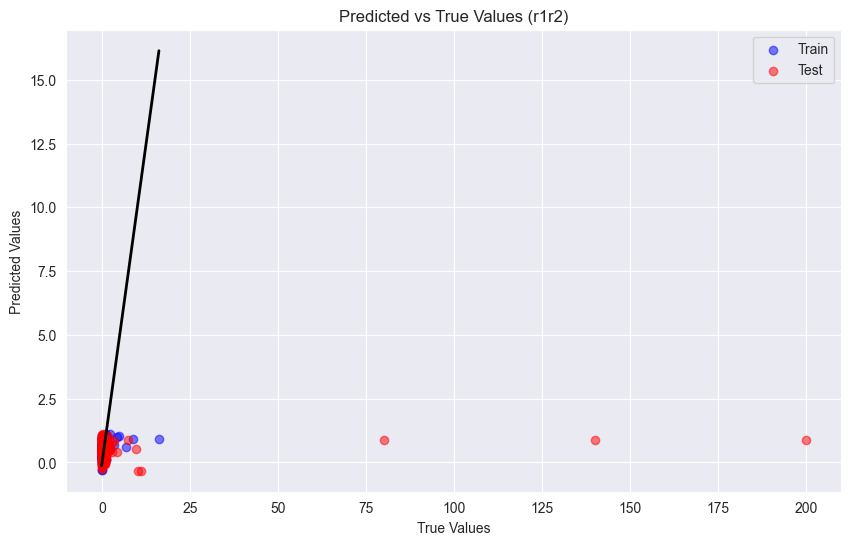

Datapoints after removing None values: 1002


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

Anzahl der Feature-Namen: 18
Anzahl der Koeffizienten: 18
Target: r1r2_sqrt
Average Training MSE: 0.2006, Average Training R2: 0.1084
Average Test MSE: 1.5647, Average Test R2: -0.0052
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}, 'ridge__alpha': 100.0, 'ridge__solver': 'saga'}
Average Feature Coefficients:
monomer1_ip: -0.0118
monomer1_ip_corrected: -0.0118
monomer1_ea: -0.0107
monomer1_homo: -0.0006
monomer1_lumo: -0.0002
monomer1_global_electrophilicity: -0.0092
monomer1_global_nucleophilicity: 0.0118
monomer2_ip: -0.0035
monomer2_ip_corrected: -0.0035
monomer2_ea: 0.0248
monomer2_homo: -0.0010
monomer2_lumo: -0.0007
monomer2_global_electrophilicity: 0.0042
monomer2_global_nucleophilicity: 0.0035
solvent_logP: -0.0610
temperature: 0.0023
method_encoded: -0.0086
calculation_method_encoded: -0.0054


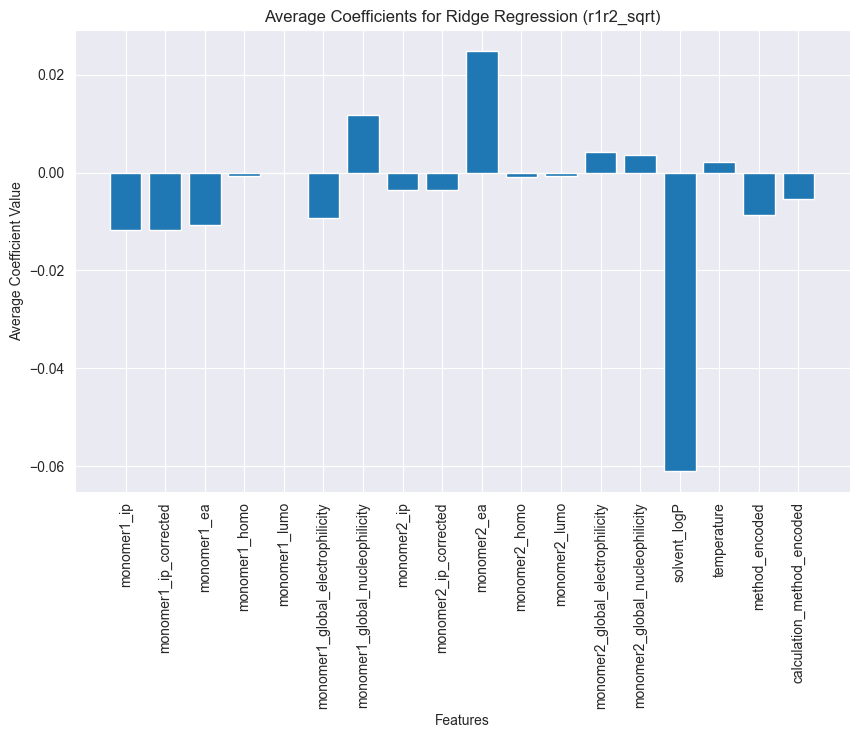

Best model saved as best_ridge_model_r1r2_sqrt.pkl


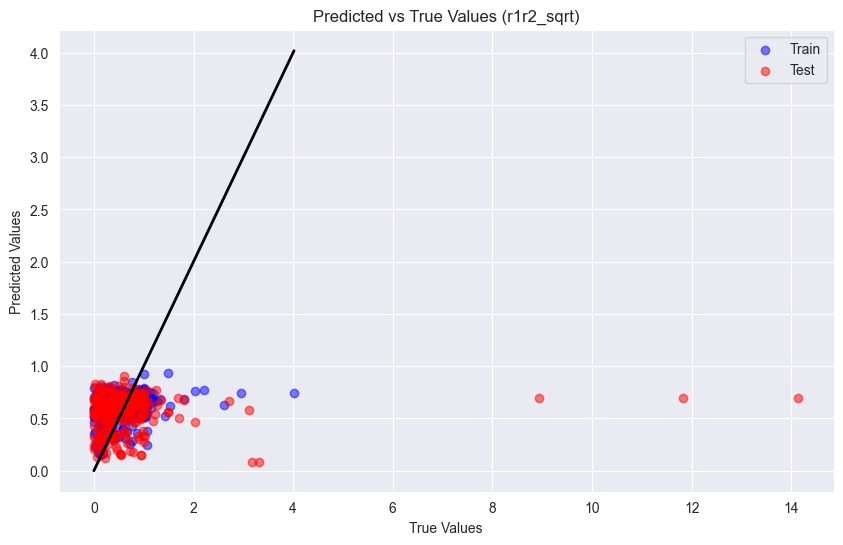

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

Datapoints after removing None values: 1002
Anzahl der Feature-Namen: 18
Anzahl der Koeffizienten: 18
Target: r1r2_log
Average Training MSE: 0.1251, Average Training R2: 0.1142
Average Test MSE: 0.3691, Average Test R2: -0.0244
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}, 'ridge__alpha': 100.0, 'ridge__solver': 'saga'}
Average Feature Coefficients:
monomer1_ip: -0.0079
monomer1_ip_corrected: -0.0079
monomer1_ea: -0.0103
monomer1_homo: -0.0005
monomer1_lumo: -0.0001
monomer1_global_electrophilicity: -0.0064
monomer1_global_nucleophilicity: 0.0079
monomer2_ip: 0.0010
monomer2_ip_corrected: 0.0010
monomer2_ea: 0.0178
monomer2_homo: -0.0008
monomer2_lumo: -0.0007
monomer2_global_electrophilicity: 0.0041
monomer2_global_nucleophilicity: -0.0010
solvent_logP: -0.0453
temperature: 0.0018
method_encoded: -0.0085
calculation_method_encoded: -0.0044


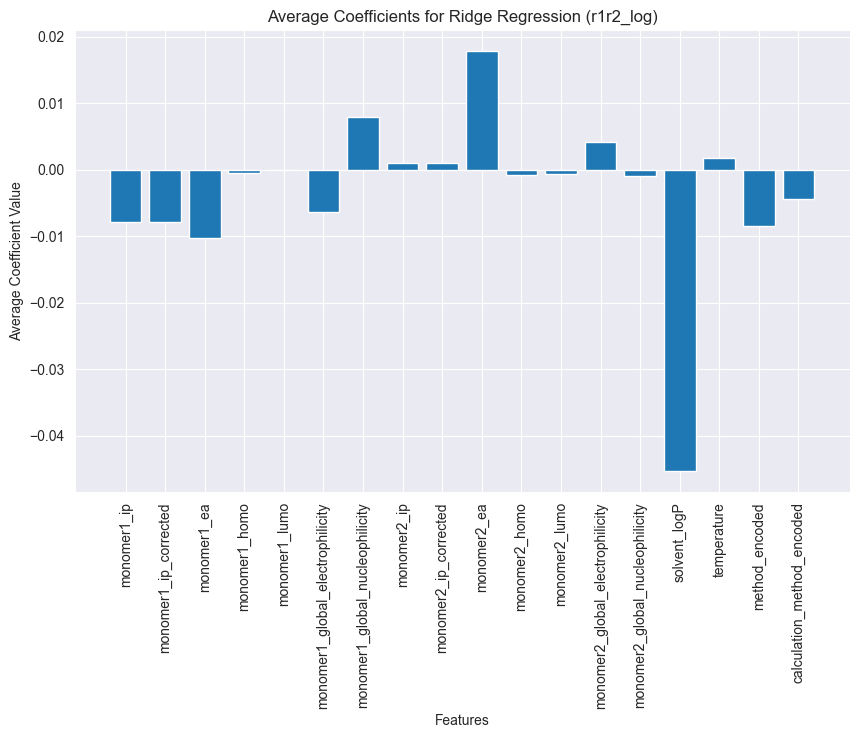

Best model saved as best_ridge_model_r1r2_log.pkl


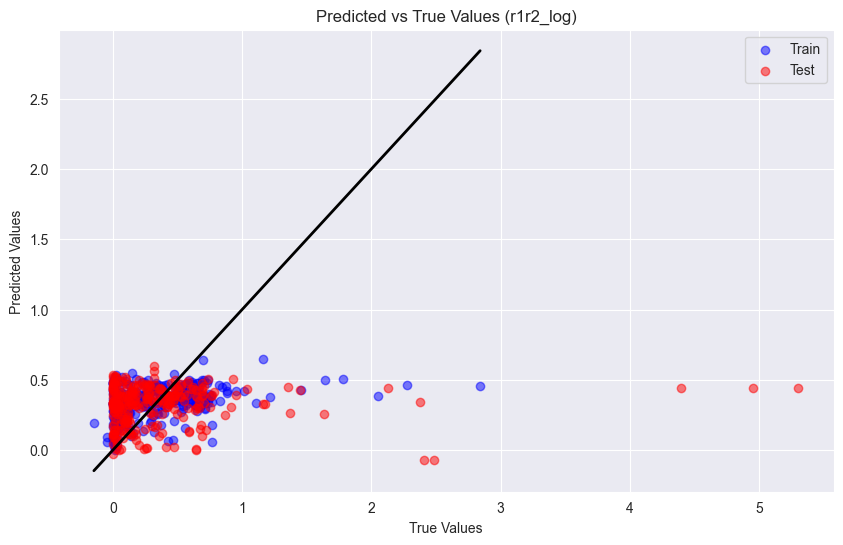

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

Datapoints after removing None values: 1002
Anzahl der Feature-Namen: 18
Anzahl der Koeffizienten: 18
Target: r1r2_power
Average Training MSE: 0.8395, Average Training R2: 0.1464
Average Test MSE: 1.0364, Average Test R2: -0.1027
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}, 'ridge__alpha': 100.0, 'ridge__solver': 'saga'}
Average Feature Coefficients:
monomer1_ip: -0.0140
monomer1_ip_corrected: -0.0140
monomer1_ea: -0.0387
monomer1_homo: -0.0016
monomer1_lumo: -0.0002
monomer1_global_electrophilicity: -0.0186
monomer1_global_nucleophilicity: 0.0140
monomer2_ip: -0.0084
monomer2_ip_corrected: -0.0084
monomer2_ea: 0.0456
monomer2_homo: -0.0015
monomer2_lumo: -0.0026
monomer2_global_electrophilicity: 0.0092
monomer2_global_nucleophilicity: 0.0084
solvent_logP: -0.1264
temperature: 0.0052
method_encoded: 0.0033
calculation_method_encoded: -0.0138


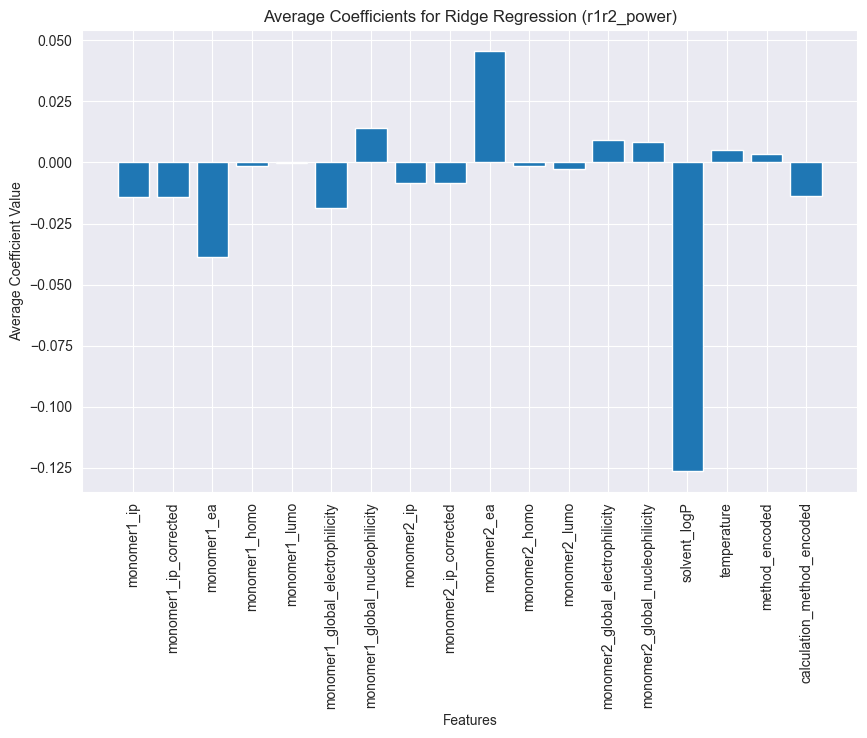

Best model saved as best_ridge_model_r1r2_power.pkl


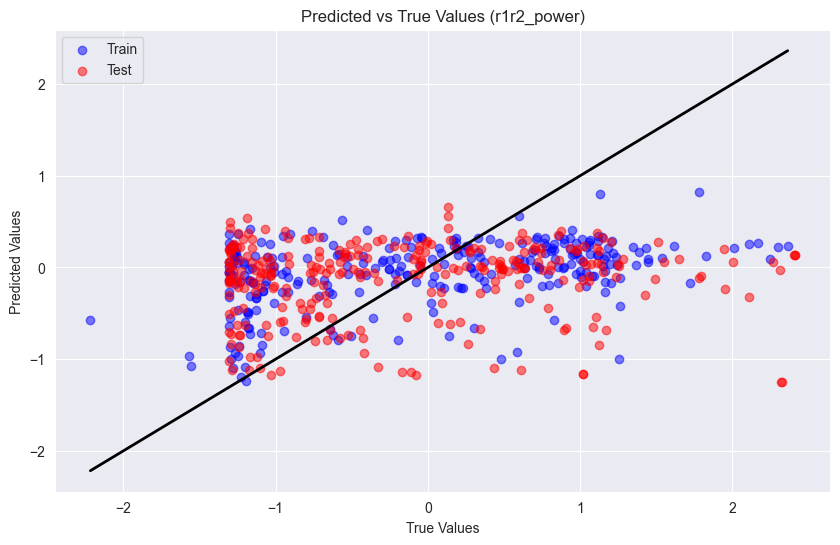

In [78]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Function to apply Power Transformation
def power_transform(column):
    pt = PowerTransformer(method='yeo-johnson')
    transformed = pt.fit_transform(column.values.reshape(-1, 1))
    return transformed.flatten()

def preprocess_data_with_transformations(df):
    # Transform r1r2 values
    df['r1r2_sqrt'] = np.sqrt(df['r1r2'])
    df['r1r2_log'] = np.log1p(df['r1r2'])
    df['r1r2_power'] = power_transform(df['r1r2'])
    
    return df

def calculate_r_product(df):
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']
    return df

# Function to select features, moved outside the main function to avoid PicklingError
def select_features(X, indices):
    return X[:, indices]

# Calculate r1r2
df_filtered = calculate_r_product(df_filtered)
# Apply transformations
df_transformed = preprocess_data_with_transformations(df_filtered)

# Funktion zum Trainieren, Bewerten und Optimieren des Ridge-Regressionsmodells
def train_evaluate_optimize(df, target_column, n_repeats=10):
    all_train_mse = []
    all_test_mse = []
    all_train_r2 = []
    all_test_r2 = []
    all_coefficients = []

    # Preprocess the data once
    all_features, regression_labels, feature_names = preprocess_data(df, target_column)

    # Splitting the data into training and testing sets (50% split for example)
    train_size = int(0.5 * len(all_features))
    train_all_features = all_features[:train_size]
    test_all_features = all_features[train_size:]
    train_regression_labels = regression_labels[:train_size]
    test_regression_labels = regression_labels[train_size:]

    # Define different feature subsets
    feature_subsets = [
        list(range(all_features.shape[1])),  # All features
        [0, 1, 2, 3, 4, 5],  # Subset 1
        [6, 7, 8, 9, 10, 11],  # Subset 2
        [0, 1, 6, 7]  # Combination of some features from both subsets
    ]

    # Create a pipeline with feature selection and Ridge regression
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),  # Optionally standardize the features
        ('feature_selector', FunctionTransformer(select_features)),  # Feature selection step
        ('ridge', Ridge())  # Ridge regression model
    ])

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'ridge__alpha': [0.1, 1.0, 10.0, 100.0],  # Different alpha values to try
        'ridge__solver': ['auto', 'svd', 'cholesky', 'saga'],  # Different solvers to test
        'feature_selector__kw_args': [{'indices': subset} for subset in feature_subsets]  # Feature subsets to test
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(train_all_features, train_regression_labels)

    # Retrieve the best model from the grid search
    best_model = grid_search.best_estimator_

    # Initialize best_test_r2 with a very low value
    best_test_r2 = -np.inf

    # Evaluate the best model multiple times
    best_train_predictions = None
    best_test_predictions = None
    for _ in range(n_repeats):
        ridge_model = best_model.named_steps['ridge']
        ridge_model.fit(train_all_features, train_regression_labels)

        # Store the coefficients
        all_coefficients.append(ridge_model.coef_)

        train_predictions = ridge_model.predict(train_all_features)
        test_predictions = ridge_model.predict(test_all_features)

        train_mse = mean_squared_error(train_regression_labels, train_predictions)
        test_mse = mean_squared_error(test_regression_labels, test_predictions)
        train_r2 = r2_score(train_regression_labels, train_predictions)
        test_r2 = r2_score(test_regression_labels, test_predictions)

        all_train_mse.append(train_mse)
        all_test_mse.append(test_mse)
        all_train_r2.append(train_r2)
        all_test_r2.append(test_r2)

        # Store predictions of the best model
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            best_train_predictions = train_predictions
            best_test_predictions = test_predictions

    avg_train_mse = np.mean(all_train_mse)
    avg_test_mse = np.mean(all_test_mse)
    avg_train_r2 = np.mean(all_train_r2)
    avg_test_r2 = np.mean(all_test_r2)

    avg_coefficients = np.mean(all_coefficients, axis=0)

    # Überprüfe die Länge der Listen
    print(f"Anzahl der Feature-Namen: {len(feature_names)}")
    print(f"Anzahl der Koeffizienten: {len(avg_coefficients)}")

    if len(feature_names) != len(avg_coefficients):
        print("Fehler: Die Anzahl der Feature-Namen stimmt nicht mit der Anzahl der Koeffizienten überein.")
        return

    print(f'Target: {target_column}')
    print(f'Average Training MSE: {avg_train_mse:.4f}, Average Training R2: {avg_train_r2:.4f}')
    print(f'Average Test MSE: {avg_test_mse:.4f}, Average Test R2: {avg_test_r2:.4f}')
    print(f'Best parameters from Grid Search: {grid_search.best_params_}')
    print(f'Average Feature Coefficients:')
    for name, coef in zip(feature_names, avg_coefficients):
        print(f'{name}: {coef:.4f}')

    # Optionally plot the average coefficients
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, avg_coefficients)
    plt.xlabel('Features')
    plt.ylabel('Average Coefficient Value')
    plt.title(f'Average Coefficients for Ridge Regression ({target_column})')
    plt.xticks(rotation=90)
    plt.show()

    # Speichern des besten Modells
    model_filename = f'best_ridge_model_{target_column}.pkl'
    joblib.dump(best_model, model_filename)
    print(f'Best model saved as {model_filename}')

    # Plot der vorhergesagten gegen die tatsächlichen Werte
    plt.figure(figsize=(10, 6))
    plt.scatter(train_regression_labels, best_train_predictions, color='blue', alpha=0.5, label='Train')
    plt.scatter(test_regression_labels, best_test_predictions, color='red', alpha=0.5, label='Test')
    plt.plot([min(train_regression_labels), max(train_regression_labels)], [min(train_regression_labels), max(train_regression_labels)], color='black', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs True Values ({target_column})')
    plt.legend()
    plt.show()

# Example usage for different transformations
train_evaluate_optimize(df_transformed, 'r1r2')
train_evaluate_optimize(df_transformed, 'r1r2_sqrt')
train_evaluate_optimize(df_transformed, 'r1r2_log')
train_evaluate_optimize(df_transformed, 'r1r2_power')


Datapoints after removing None values: 1002
test: 171, train: 399


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_96420/4275758026.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 1.0}
Best R² score during cross-validation:  0.2347003581419383


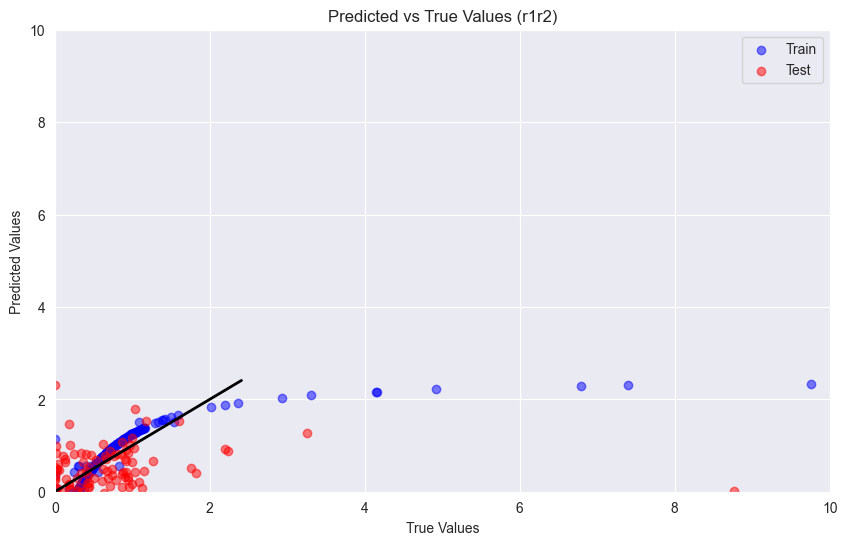

Average Training MSE: 0.0600, Average Training R2: 0.9379
Average Test MSE: 0.7983, Average Test R2: 0.2592


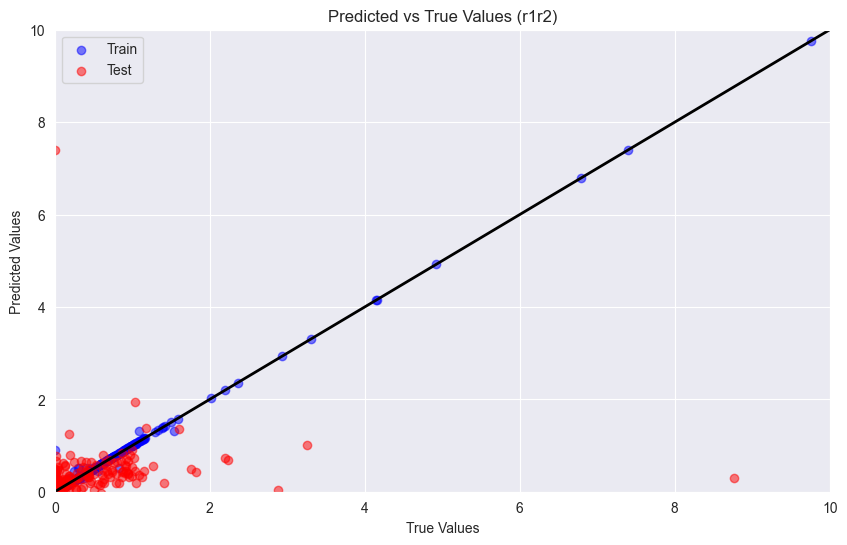

In [108]:
 from xgboost import XGBRegressor
 import numpy as np
 from sklearn.model_selection import train_test_split, GridSearchCV
 from sklearn.metrics import mean_squared_error, r2_score
 from sklearn.preprocessing import PowerTransformer
 import matplotlib.pyplot as plt

 def train_evaluate_weighted_xgb(df, target_column):
     # Preprocess the data
     all_features, regression_labels, feature_names = preprocess_data(df, target_column)

     # Power Transformation for features
     pt_features = PowerTransformer(method='yeo-johnson')
     all_features = pt_features.fit_transform(all_features)

     # Power Transformation for the target variable
     target_transformer = PowerTransformer(method='yeo-johnson')
     regression_labels_transformed = target_transformer.fit_transform(regression_labels.reshape(-1, 1)).flatten()

     # Compute sample weights based on the original (not transformed) target values
     sample_weights = np.abs(regression_labels) + 1e-3  # Ensure all weights are positive

     # Split the data (including sample_weights)
     train_all_features, test_all_features, train_regression_labels, test_regression_labels, train_weights, test_weights = train_test_split(
         all_features, regression_labels_transformed, sample_weights, test_size=0.3, random_state=42
     )
     
     print(f'test: {len(test_all_features)}, train: {len(train_all_features)}')

     # Define the XGBoost model
     xgb_model = XGBRegressor()

     # Define the parameter grid for hyperparameter tuning
     param_grid = {
         'n_estimators': [200, 500, 1000],
         'learning_rate': [0.01, 0.1, 0.3],
         'max_depth': [3, 5, 7, 10],
         'min_child_weight': [1, 3, 5],
         'subsample': [0.8, 1.0],
         'colsample_bytree': [0.8, 1.0],
         'gamma': [0, 0.1, 0.3]
     }

     # Perform Grid Search with cross-validation
     grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
     grid_search.fit(train_all_features, train_regression_labels, sample_weight=train_weights)

     # Retrieve the best model and parameters
     best_model = grid_search.best_estimator_
     print("Best parameters found: ", grid_search.best_params_)
     print("Best R² score during cross-validation: ", grid_search.best_score_)

     # Make predictions with the best model
     train_predictions_transformed = best_model.predict(train_all_features)
     test_predictions_transformed = best_model.predict(test_all_features)
     
     # Plot the results with the inverse-transformed predictions
     plt.figure(figsize=(10, 6))
     plt.scatter(target_transformer.inverse_transform(train_regression_labels.reshape(-1, 1)).flatten(), train_predictions_transformed, color='blue', alpha=0.5, label='Train')
     plt.scatter(target_transformer.inverse_transform(test_regression_labels.reshape(-1, 1)).flatten(), test_predictions_transformed, color='red', alpha=0.5, label='Test')
     plt.plot([min(train_predictions_transformed), max(train_predictions_transformed)], [min(train_predictions_transformed), max(train_predictions_transformed)], color='black', lw=2)
     plt.xlabel('True Values')
     plt.ylabel('Predicted Values')
     plt.title(f'Predicted vs True Values ({target_column})')
     
     plt.xlim(0, 10)
     plt.ylim(0, 10)
     
     plt.legend()
     
     plt.savefig('prediction_XGBoost_transformed.png', bbox_inches='tight', dpi=300)
     plt.show()

     # Inverse transform the predictions only for visualization
     train_predictions_vis = target_transformer.inverse_transform(train_predictions_transformed.reshape(-1, 1)).flatten()
     test_predictions_vis = target_transformer.inverse_transform(test_predictions_transformed.reshape(-1, 1)).flatten()

     # Evaluate performance on the transformed scale
     train_mse = mean_squared_error(train_regression_labels, train_predictions_transformed)
     test_mse = mean_squared_error(test_regression_labels, test_predictions_transformed)
     train_r2 = r2_score(train_regression_labels, train_predictions_transformed)
     test_r2 = r2_score(test_regression_labels, test_predictions_transformed)

     print(f'Average Training MSE: {train_mse:.4f}, Average Training R2: {train_r2:.4f}')
     print(f'Average Test MSE: {test_mse:.4f}, Average Test R2: {test_r2:.4f}')

     # Plot the results with the inverse-transformed predictions
     plt.figure(figsize=(10, 6))
     plt.scatter(target_transformer.inverse_transform(train_regression_labels.reshape(-1, 1)).flatten(), train_predictions_vis, color='blue', alpha=0.5, label='Train')
     plt.scatter(target_transformer.inverse_transform(test_regression_labels.reshape(-1, 1)).flatten(), test_predictions_vis, color='red', alpha=0.5, label='Test')
     plt.plot([min(train_predictions_vis), max(train_predictions_vis)], [min(train_predictions_vis), max(train_predictions_vis)], color='black', lw=2)
     plt.xlabel('True Values')
     plt.ylabel('Predicted Values')
     plt.title(f'Predicted vs True Values ({target_column})')
     
     plt.xlim(0, 10)
     plt.ylim(0, 10)
     
     plt.legend()
     
     plt.savefig('prediction_XGBoost.png', bbox_inches='tight', dpi=300)
     plt.show()

 # Call the function to perform training and evaluation
 train_evaluate_weighted_xgb(df_transformed, 'r1r2')